# Import

In [2]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit, minimize, differential_evolution
from Genetic_algorithm import generate_Initial_Parameters
from Minimization_functions import *
from Resonator_formula import *
import warnings
import time as ti
from functools import partial

# Example with PS kicker KFA21
I want to study the vertical dipolar component of the impedance but it also works with the other components of course

In [3]:
impedance_file = pd.read_csv('PE.KFA21_CST_2015_10GHz.imp', 
                             sep='\s+', index_col=False, 
                             names=["f", "Re(Zdipx)", "Im(Zdipx)", 
                                    "Re(Zdipy)", "Im(Zdipy)",
                                    "Re(Zquadx)", "Im(Zquadx)",
                                    "Re(Zquady)", "Im(Zquady)"], header=0)

#Studied component
component = "Zdipy"

#Number of resonators
Nres = 3

#x,y_array correspond to all the data (x=0 excluded to avoid dividing by 0)
#frequencies in GHz and impedances in Ohm/m


#x_array, impedance_data = f_window_test(impedance_file, component, 1e-15, np.inf)
frequency_data = impedance_file['f'].to_numpy() #frequencies in GHz
impedance_data = np.array(impedance_file['Re({})'.format(component)] + \
                          1j*impedance_file['Im({})'.format(component)])

""" Bounds on resonators parameters, it's possible to manually set them as well.
Bounds have this format [(Rt_min, Rtmax), (Q_min, Q_max), (fres_min, fres_max)].
ParameterBounds allows us to manually add a resonator with desired parameters """
bounds = [(-7e5, 7e5), (0, 20), (0, 10e9)]
parameterBounds = [(-7e5, 7e5), (0, 20), (1e-1, 10e9)] + (Nres-1)*bounds

###############################################################################

t0 = ti.perf_counter()

#Generate initial parameter values using our bounds
initialParameters, _ = generate_Initial_Parameters(parameterBounds, minimizationFunction=sumOfSquaredError,
                                                fitFunction=n_Resonator_transverse_imp,
                                                x_values_data=frequency_data, y_values_data=impedance_data)


t1 = ti.perf_counter()


#Curve fit the impedance using initial parameters from genetic algorithm
minimization_function = partial(sumOfSquaredError, fitFunction=n_Resonator_transverse_imp,
                                frequencies=frequency_data, impedance_data=impedance_data)
pars = minimize(minimization_function, x0=initialParameters, bounds=parameterBounds,
                method='Powell', options={'maxfev': 100000, 'disp': True})
pars = pars.x

t2 = ti.perf_counter()

print('\n')
print("Elapsed time for genetic algorithm={:.2f} s".format(t1-t0))
print("Elapsed time for curve fit algorithm={:.2f} s".format(t2-t1))
###############################################################################

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:533: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"


 Progress : [####################] 100%
Resonator 1
Rt = 9.90e+04 [Ohm/m], Q = 1.97, fres = 7.42e+08 [Hz]
------------------------------------------------------------
Resonator 2
Rt = 2.57e+04 [Ohm/m], Q = 0.67, fres = 1.89e+09 [Hz]
------------------------------------------------------------
Resonator 3
Rt = -1.46e+04 [Ohm/m], Q = 1.05, fres = 3.73e+08 [Hz]
------------------------------------------------------------
Optimization terminated successfully.
         Current function value: 13823997874.140913
         Iterations: 2
         Function evaluations: 349


Elapsed time for genetic algorithm=59.44 s
Elapsed time for curve fit algorithm=0.18 s


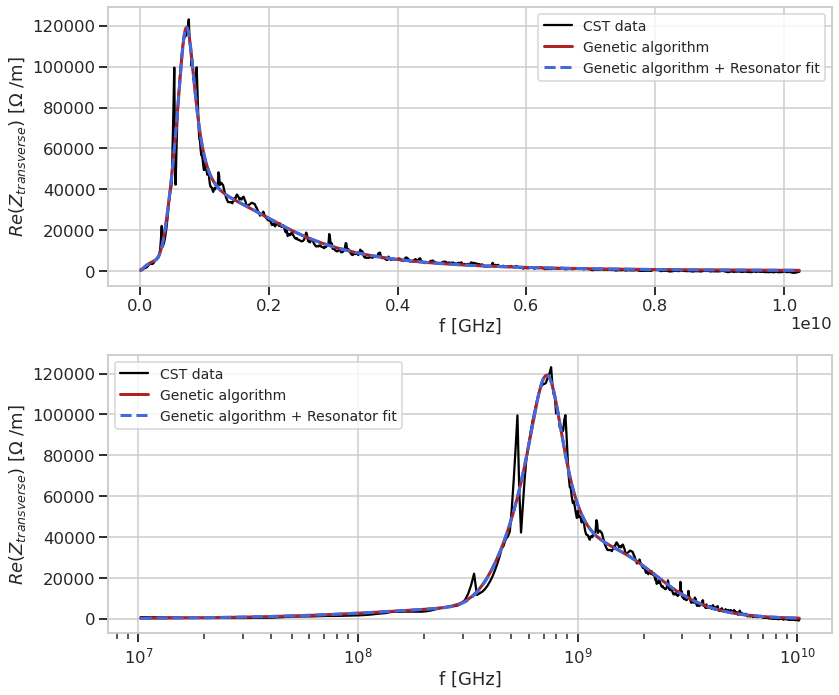

In [4]:
#Plot real part of impedance
sns.set_style(style="whitegrid", rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_context('talk')

fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(12,10))

ax0.plot(frequency_data, impedance_data.real, "black", label='CST data')
ax0.plot(frequency_data, n_Resonator_transverse_real(frequency_data, *initialParameters),
         lw = 3, color='firebrick', label='Genetic algorithm')
ax0.plot(frequency_data, n_Resonator_transverse_real(frequency_data, *pars), 'royalblue',
         lw = 3, linestyle='--', label='Genetic algorithm + Resonator fit')


ax1.plot(frequency_data, impedance_data.real, "black", label='CST data')
ax1.plot(frequency_data, n_Resonator_transverse_real(frequency_data, *initialParameters),
         lw = 3, color='firebrick', label='Genetic algorithm')
ax1.plot(frequency_data, n_Resonator_transverse_real(frequency_data, *pars), 'royalblue',
         lw = 3, linestyle='--', label='Genetic algorithm + Resonator fit')


ax1.set_xscale('log')

ax0.set_xlabel('f [GHz]')
ax1.set_xlabel('f [GHz]')

ax0.set_ylabel('$Re(Z_{transverse})$ [$\Omega$ /m]')
ax1.set_ylabel('$Re(Z_{transverse})$ [$\Omega$ /m]')

ax0.legend(loc='best', fontsize=14)
ax1.legend(loc='best', fontsize=14)

fig.tight_layout()

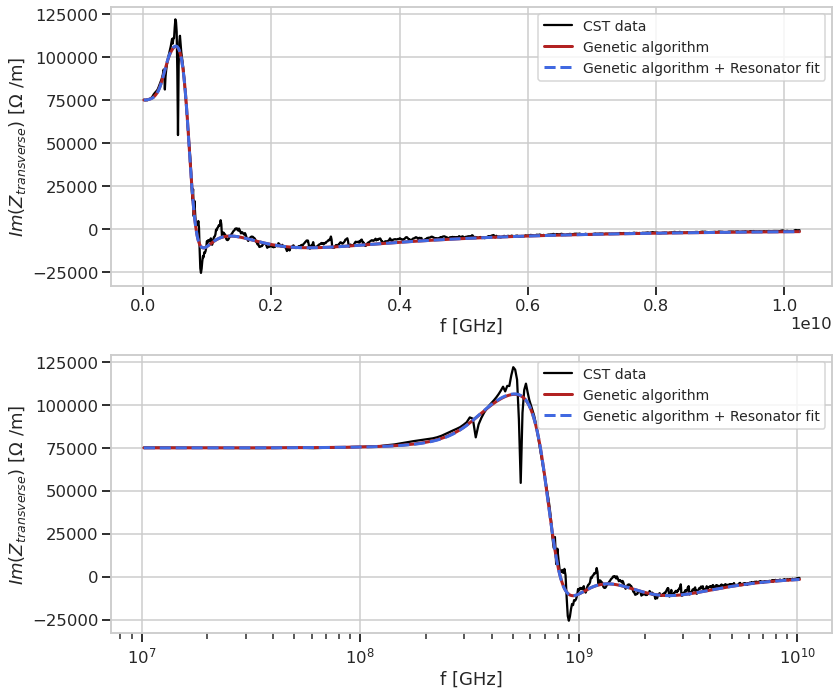

In [5]:
#Plot imaginary part of impedance

fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(12,10))

ax0.plot(frequency_data, impedance_data.imag, "black", label='CST data')
ax0.plot(frequency_data, n_Resonator_transverse_imag(frequency_data, *initialParameters),
         lw = 3, color='firebrick', label='Genetic algorithm')
ax0.plot(frequency_data, n_Resonator_transverse_imag(frequency_data, *pars), 'royalblue',
         lw = 3, linestyle='--', label='Genetic algorithm + Resonator fit')


ax1.plot(frequency_data, impedance_data.imag, "black", label='CST data')
ax1.plot(frequency_data, n_Resonator_transverse_imag(frequency_data, *initialParameters),
         lw = 3, color='firebrick', label='Genetic algorithm')
ax1.plot(frequency_data, n_Resonator_transverse_imag(frequency_data, *pars), 'royalblue',
         lw = 3, linestyle='--', label='Genetic algorithm + Resonator fit')
ax1.set_xscale('log')

ax0.set_xlabel('f [GHz]')
ax1.set_xlabel('f [GHz]')

ax0.set_ylabel('$Im(Z_{transverse})$ [$\Omega$ /m]')
ax1.set_ylabel('$Im(Z_{transverse})$ [$\Omega$ /m]')

ax0.legend(loc='best', fontsize=14)
ax1.legend(loc='best', fontsize=14)

fig.tight_layout()

# Crosscheck with the wake
Here I load the CST wake and compare with the wake function reconstruction obtained from the fitted resonators parameters

In [6]:
#Load data from wake file
wake_data = pd.read_csv('PE.KFA21_CST_2015_10GHz.wake', 
                        sep='\s+', index_col=False, names=["t", "Wdipx", "Wdipy",
                                                           "Wquadx", "Wquady"])
#Choose which component to study
component = "Wdipy"
Nres = 3

wake_data = wake_data.loc[wake_data['t'] >= 0]
t_array = np.array(wake_data['t'])
Wt_array = np.array(wake_data[component])

"""#It's also possible to fit the wake with this part, by default it's not used
bounds = [(-1.1e5, 1.1e5), (0, 3), (0, 1.e9)]
parameterBounds = [(-1e5, 1e5), (0, 3), (1e-1, 1.7e9)] + (Nres-1)*bounds

t0 = ti.perf_counter()

#Generate initial parameter values using our bounds
initialParameters, _ = generate_Initial_Parameters(parameterBounds, minimizationFunction=sumOfSquaredError2,
                                                fitFunction=n_Resonator_transverse_wake,
                                                x_values_data=t_array, y_values_data=Wt_array,
                                                maxiter=20000, popsize=50, tol=0.005, 
)


t1 = ti.perf_counter()


#Curve fit the impedance using initial parameters from genetic algorithm
minimization_function = partial(sumOfSquaredError2, fitFunction=n_Resonator_transverse_wake,
                                frequencies=t_array, impedance_data=Wt_array)
pars = minimize(minimization_function, x0=initialParameters, bounds=parameterBounds,
                method='Powell', options={'maxfev': 100000, 'disp': True})
pars = pars.x

t2 = ti.perf_counter()

print('\n')
print("Elapsed time for genetic algorithm={:.2f} s".format(t1-t0))
print("Elapsed time for curve fit algorithm={:.2f} s".format(t2-t1))"""

'#It\'s also possible to fit the wake with this part, by default it\'s not used\nbounds = [(-1.1e5, 1.1e5), (0, 3), (0, 1.e9)]\nparameterBounds = [(-1e5, 1e5), (0, 3), (1e-1, 1.7e9)] + (Nres-1)*bounds\n\nt0 = ti.perf_counter()\n\n#Generate initial parameter values using our bounds\ninitialParameters, _ = generate_Initial_Parameters(parameterBounds, minimizationFunction=sumOfSquaredError2,\n                                                fitFunction=n_Resonator_transverse_wake,\n                                                x_values_data=t_array, y_values_data=Wt_array,\n                                                maxiter=20000, popsize=50, tol=0.005, \n)\n\n\nt1 = ti.perf_counter()\n\n\n#Curve fit the impedance using initial parameters from genetic algorithm\nminimization_function = partial(sumOfSquaredError2, fitFunction=n_Resonator_transverse_wake,\n                                frequencies=t_array, impedance_data=Wt_array)\npars = minimize(minimization_function, x0=initialPa

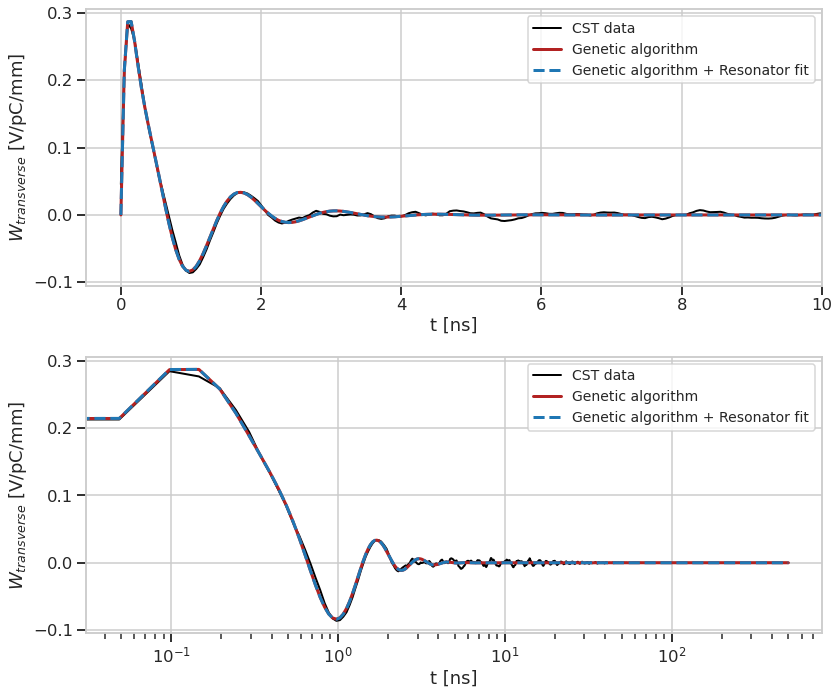

In [8]:
sns.set_style(style="whitegrid", rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_context('talk')


fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(12,10))

ax0.plot(t_array*1e9, Wt_array, "black", lw=2, label='CST data')
ax0.plot(t_array*1e9, n_Resonator_transverse_wake(t_array, *initialParameters)*1e-15,
         lw = 3, color='firebrick', label='Genetic algorithm')
ax0.plot(t_array*1e9, n_Resonator_transverse_wake(t_array, *pars)*1e-15,
         lw = 3, linestyle='--', label='Genetic algorithm + Resonator fit')


ax1.plot(t_array*1e9, Wt_array, "black", lw=2, label='CST data')
ax1.plot(t_array*1e9, n_Resonator_transverse_wake(t_array, *initialParameters)*1e-15,
         lw = 3, color='firebrick', label='Genetic algorithm')
ax1.plot(t_array*1e9, n_Resonator_transverse_wake(t_array, *pars)*1e-15,
         lw = 3, linestyle='--', label='Genetic algorithm + Resonator fit')
ax1.set_xscale('log')

ax0.set_xlabel('t [ns]')
ax1.set_xlabel('t [ns]')

ax0.set_ylabel('$W_{transverse}$ [V/pC/mm]')
ax1.set_ylabel('$W_{transverse}$ [V/pC/mm]')

ax0.set_xlim(-0.5, 10)

ax0.legend(loc='best', fontsize=14)
ax1.legend(loc='best', fontsize=14)

fig.tight_layout()